In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore', UserWarning)

In [2]:
def split_data(characteristics, characteristics_adv, noise, test_size=0.2, random_state=42):
    
    shape_adv = np.shape(characteristics_adv)[0]
    shape_char = np.shape(characteristics)[0]
    
    # import pdb; pdb.set_trace()
    
    if not noise:
        adv_X_train_val, adv_X_test, adv_y_train_val, adv_y_actual = train_test_split(characteristics_adv, np.ones(shape_adv),   test_size=test_size, random_state=random_state)
        b_X_train_val, b_X_test, b_y_train_val, b_y_actual         = train_test_split(characteristics,     np.zeros(shape_char), test_size=test_size, random_state=random_state)
        adv_X_train, adv_X_val, adv_y_train, adv_y_val             = train_test_split(adv_X_train_val,     adv_y_train_val,      test_size=test_size, random_state=random_state)
        b_X_train, b_X_val, b_y_train, b_y_val                     = train_test_split(b_X_train_val,       b_y_train_val,        test_size=test_size, random_state=random_state)
    else:
        adv_X_train_val, adv_X_test, adv_y_train_val, adv_y_actual = train_test_split(characteristics_adv,    np.ones(shape_adv),  test_size=test_size, random_state=random_state)
        b_X_train_val, b_X_test, b_y_train_val, b_y_actual         = train_test_split(characteristics[:shape_adv], np.zeros(shape_adv), test_size=test_size, random_state=random_state)
        # b_X_train_val3, b_X_test3, b_y_train_val3, b_y_actual3     = train_test_split(characteristics[:2000], np.zeros(shape_adv), test_size=test_size, random_state=random_state)
        b_X_train_val2, b_X_test2, b_y_train_val2, b_y_actual2     = train_test_split(characteristics[shape_adv:], np.zeros(shape_adv), test_size=test_size, random_state=random_state)
        
        b_X_train_val = np.concatenate((b_X_train_val, b_X_train_val2))
        b_X_test = np.concatenate((b_X_test, b_X_test2))
        b_y_train_val = np.concatenate((b_y_train_val, b_y_train_val2))
        b_y_actual = np.concatenate((b_y_actual, b_y_actual2)) 
        
        adv_X_train, adv_X_val, adv_y_train, adv_y_val           = train_test_split(adv_X_train_val,     adv_y_train_val,      test_size=test_size, random_state=random_state)
        b_X_train, b_X_val, b_y_train, b_y_val                   = train_test_split(b_X_train_val,       b_y_train_val,        test_size=test_size, random_state=random_state)


    X_train = np.concatenate(( b_X_train, adv_X_train) )
    y_train = np.concatenate(( b_y_train, adv_y_train) )

    X_test = np.concatenate( (b_X_test, adv_X_test, b_X_val, adv_X_val) )
    y_actual = np.concatenate( (b_y_actual, adv_y_actual, b_y_val, adv_y_val) )


    return X_train, y_train, X_test, y_actual

In [3]:
def RF(X_train, y_train, X_test, y_test):
    scaler  = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test  = scaler.transform(X_test)
    clf = RandomForestClassifier(n_estimators=300, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_hat =    clf.predict(X_test)
    y_hat_pr = clf.predict_proba(X_test)[:, 1]
    
    return y_hat, y_hat_pr

In [4]:
def LR(X_train, y_train, X_test, y_test):
    scaler  = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test  = scaler.transform(X_test)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_hat =    clf.predict(X_test)
    y_hat_pr = clf.predict_proba(X_test)[:, 1]
    
    return y_hat, y_hat_pr

In [5]:
stepsize = 10

# tmp = torch.load("./../data/extracted_characteristics/run_1/cif10/wrn_28_10_10/{}/multiLID/characteristics".format('fgsm'))

tmp = torch.load("./../data/extracted_characteristics/run_1/imagenet/wrn_50_2/{}/multiLID/characteristics".format('fgsm'))
tmp = characteristics_re.reshape((tmp.shape[0], -1))

samples, length = tmp.shape

NameError: name 'characteristics_re' is not defined

In [119]:
for i in range(stepsize, length+stepsize, stepsize):
    print(i, characteristics_re[:, :i].shape)
    
    clean_feat  = characteristics_re[:, :i]
    attack_feat = characteristics_adv_re[:, :i]
    
    X_train, y_train, X_test, y_test = split_data(clean_feat, attack_feat, noise=False, test_size=0.2, random_state=42)
    y_hat, y_hat_pr = LR(X_train, y_train, X_test, y_test)
    auc = round(100*roc_auc_score(y_test, y_hat_pr), 2)
    f1 =  round(100*f1_score(y_test, y_hat), 2)
    
    y_hat, y_hat_pr = RF(X_train, y_train, X_test, y_test)
    auc_rf = round(100*roc_auc_score(y_test, y_hat_pr), 2)
    f1_rf =  round(100*f1_score(y_test, y_hat), 2)
    print(auc, auc_rf, '|| f1: ', f1, f1_rf)

10 (2000, 10)
57.13 56.1 || f1:  58.53 57.86
20 (2000, 20)
97.94 97.63 || f1:  95.18 95.15
30 (2000, 30)
97.94 97.94 || f1:  95.46 95.26
40 (2000, 40)
97.97 97.8 || f1:  95.79 95.99
50 (2000, 50)
97.96 98.01 || f1:  95.78 95.93
60 (2000, 60)
97.92 98.11 || f1:  96.06 95.87
70 (2000, 70)
97.98 98.12 || f1:  96.13 95.88
80 (2000, 80)
97.97 98.04 || f1:  96.13 95.94
90 (2000, 90)
97.94 97.78 || f1:  96.07 96.01
100 (2000, 100)
97.89 97.9 || f1:  95.73 96.28
110 (2000, 110)
97.9 97.93 || f1:  96.14 96.28
120 (2000, 120)
97.93 97.98 || f1:  96.47 96.35
130 (2000, 130)
98.08 97.97 || f1:  96.33 96.41
140 (2000, 140)
98.05 98.09 || f1:  96.26 96.41
150 (2000, 150)
98.2 98.19 || f1:  96.66 96.75
160 (2000, 160)
98.27 98.39 || f1:  96.24 96.88
170 (2000, 170)
98.29 98.38 || f1:  96.51 97.01
180 (2000, 180)
98.29 98.39 || f1:  96.51 96.87
190 (2000, 190)
98.28 98.57 || f1:  96.58 96.95
200 (2000, 200)
98.33 98.55 || f1:  96.31 97.08
210 (2000, 210)
98.28 98.5 || f1:  96.16 97.01
220 (2000, 220)


In [8]:
def calc_auc(attacks, mode="cif10", stepsize=10):

    
    dict_res = {}
    
    length = 0
    
    for att in attacks:
        print("attack", att)
        
        if mode == "cif10":
            pth_tmp             = "./../data/extracted_characteristics/run_1/cif10/wrn_28_10_10/{}/multiLID/characteristics".format(att)
            pth_tmp_adv         = "./../data/extracted_characteristics/run_1/cif10/wrn_28_10_10/{}/multiLID/characteristics_adv".format(att)
        else:    
            pth_tmp             = "./../data/extracted_characteristics/run_1/imagenet/wrn_50_2/{}/multiLID/characteristics".format(att)
            pth_tmp_adv         = "./../data/extracted_characteristics/run_1/imagenet/wrn_50_2/{}/multiLID/characteristics_adv".format(att)

        characteristics = torch.load(pth_tmp)[:2000]
        characteristics_adv = torch.load(pth_tmp_adv)[:2000]

        characteristics_re     = characteristics.reshape((characteristics.shape[0], -1))
        characteristics_adv_re = characteristics_adv.reshape((characteristics_adv.shape[0], -1))
        
        characteristics_re     = characteristics_re[:,::-1]    
        characteristics_adv_re = characteristics_adv_re[:,::-1]
        
        nrsamples, length = characteristics_re.shape
        print("length", length, stepsize)
        
        auc_list = []

        for i in range(0, length+stepsize, stepsize):

            if not i == 0:
                clean_feat  = characteristics_re[:, :i]
                attack_feat = characteristics_adv_re[:, :i]

                X_train, y_train, X_test, y_test = split_data(clean_feat, attack_feat, noise=False, test_size=0.2, random_state=42)


                y_hat, y_hat_pr = RF(X_train, y_train, X_test, y_test)
                auc = round(100*roc_auc_score(y_test, y_hat_pr), 2)
                f1_rf =  round(100*f1_score(y_test, y_hat), 2)
                # print(auc, auc_rf, '|| f1: ', f1, f1_rf) 

                #print("auc", auc, f1_rf)

            else:
                auc = 0

            auc_list.append(auc)

        dict_res[att] = auc_list 

    return dict_res, length

In [9]:
attacks = ['fgsm', 'bim', 'pgd', 'aa', 'df', 'cw']
stepsize = 10
labels = ['FGSM', 'BIM', 'PGD', 'AA', 'DF', 'CW']
cdict  = {0: 'blue', 1: 'red', 2: 'green', 3: 'cyan', 4: 'orange', 5: 'purple'}


In [7]:
dict_res, length = calc_auc(attacks, mode="cif10")

NameError: name 'calc_auc' is not defined

In [57]:
x = np.arange(0, length+stepsize, stepsize)

In [58]:
len(dict_res['fgsm'])

27

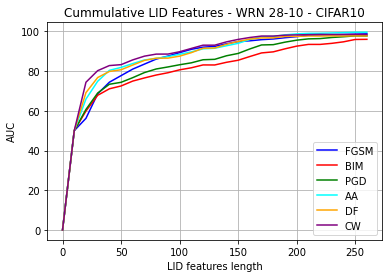

In [59]:
fig, ax = plt.subplots()
plt.title('Cummulative LID Features - WRN 28-10 - CIFAR10')
plt.ylabel("AUC")
plt.xlabel("LID features length")
for it, att in enumerate(attacks):
    plt.plot(x, dict_res[att], label=labels[it], color=cdict[it])

plt.grid()
plt.legend()

ax.figure.savefig("plots/cummulative_lid_features/cummulative_lid_features_cifar10.png", dpi=600, bbox_inches='tight')

# ImageNet

In [16]:
dict_res, length = calc_auc(attacks, mode="imagenet")

attack fgsm
length 510 10
attack bim
length 510 10
attack pgd
length 510 10
attack aa
length 510 10
attack df
length 510 10
attack cw
length 510 10


In [17]:
x = np.arange(0, length+stepsize, stepsize)

In [18]:
len(dict_res["fgsm"])

52

In [19]:
len(x)

52

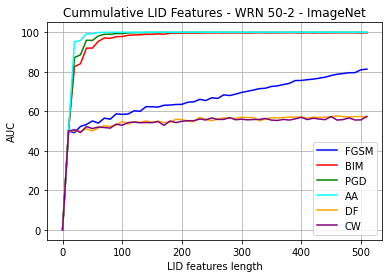

In [20]:
attacks = ['fgsm', 'bim', 'pgd', 'aa', 'df', 'cw']
fig, ax = plt.subplots()
plt.title('Cummulative LID Features - WRN 50-2 - ImageNet')
plt.ylabel("AUC")
plt.xlabel("LID features length")
for it, att in enumerate(attacks):
    plt.plot(x, dict_res[att], label=labels[it], color=cdict[it])

plt.grid()
plt.legend()

#ax.figure.savefig("plots/cummulative_lid_features/cummulative_lid_features_imagenet.png", dpi=600, bbox_inches='tight')